# RL coursework, part I (20 pts total)
---

**Name:** Victor Fizesan

**SN:** 20009434

---

**Due date:** *April 10th, 2025*

---
Standard UCL policy (including grade deductions) automatically applies for any late submissions.


## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part1.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

----
**Reminder of copyrights**

Copyrights protect this code/content and distribution or usages of it (or parts of it) without permission is prohibited. This includes uploading it and usage of it in training in any LLMs systems.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [18]:
# Import Useful Libraries

import collections
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Import Seaborn

np.set_printoptions(precision=3, suppress=1)
sns.set_theme(style="white")

# Fix font issue
plt.rcParams.update({
    'font.family': 'Arial',        
    'mathtext.fontset': 'stix',    
    'text.usetex': False,          
})

In [19]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [20]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f

    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif

      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [21]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])

      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)

      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [22]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.

    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.

    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [23]:
class UCB(object):
  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self._bonus_multiplier = bonus_multiplier
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is not None:
      self._counts[previous_action] += 1
      n = self._counts[previous_action]
      value = self._values[previous_action]
      self._values[previous_action] += (reward - value) / n

    self._total_steps += 1

    for i in range(self._number_of_arms):
      if self._counts[i] == 0:
        return i  # ensure every arm is tried once

    bonuses = self._bonus_multiplier * np.sqrt(
      np.log(self._total_steps) / self._counts
    )
    ucb_values = self._values + bonuses
    return np.argmax(ucb_values)

  def reset(self):
    self._counts = np.zeros(self._number_of_arms)
    self._values = np.zeros(self._number_of_arms)
    self._total_steps = 0

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [24]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    self.name = name
    self._number_of_arms = number_of_arms

    # Allow constant or time-varying epsilon
    if callable(epsilon):
      self._epsilon_fn = epsilon
    else:
      self._epsilon_fn = lambda t: epsilon

    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    if previous_action is not None:
      self._counts[previous_action] += 1
      n = self._counts[previous_action]
      value = self._values[previous_action]
      self._values[previous_action] += (reward - value) / n

    epsilon = self._epsilon_fn(max(1, self._total_steps))
    self._total_steps += 1

    if np.random.rand() < epsilon:
      action = np.random.randint(self._number_of_arms)
    else:
      max_value = np.max(self._values)
      best_actions = np.where(self._values == max_value)[0]
      action = np.random.choice(best_actions)

    return action

  def reset(self):
    self._counts = np.zeros(self._number_of_arms)
    self._values = np.zeros(self._number_of_arms)
    self._total_steps = 0

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


From the `square-max`, the gradient for action *a* is derived from:

$$
\nabla_{p(a)} \log \pi(a) = \frac{2p(a) \left( \sum_b p(b)^2 - p(a)^2 \right)}{\left( \sum_b p(b)^2 \right)^2}
$$

In [25]:
class REINFORCE(object):
  def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
    self.name = name
    self.n_arms = number_of_arms
    self.alpha = step_size
    self.baseline = baseline
    self.b = 0.0
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is not None:
      advantage = reward - self.b if self.baseline else reward
      grad = 2 * self.p
      grad[previous_action] *= (self.sum_sq_p - self.p[previous_action]**2)
      grad -= self.p[previous_action]**2 * (2 * self.p)
      grad /= self.sum_sq_p**2
      self.p[previous_action] += self.alpha * advantage * grad[previous_action]
      if self.baseline:
        self.b += self.alpha * advantage

    self.sum_sq_p = np.sum(self.p**2)
    pi = self.p**2 / self.sum_sq_p
    action = np.random.choice(self.n_arms, p=pi)
    
    return action

  def reset(self):
    self.p = np.ones(self.n_arms)
    self.sum_sq_p = np.sum(self.p**2)

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [26]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

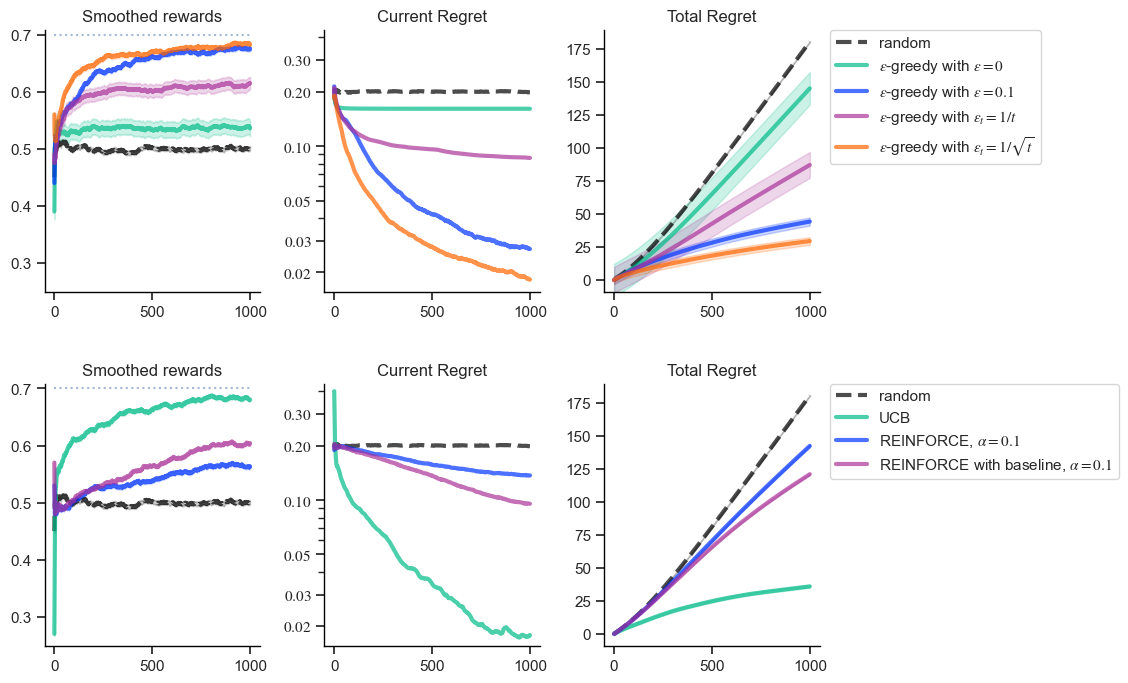

In [27]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.

- **Random**: This baseline algorithm selects actions uniformly at random without learning. Its regret grows linearly, making it a poor choice in general. We should not expect good performance from this method.

- **UCB (Upper Confidence Bound)**: UCB performs very well in terms of total regret and has strong theoretical guarantees. Specifically, it achieves logarithmic regret in stochastic multi-armed bandits (Auer et al., 2002). It effectively balances exploration and exploitation and is generally expected to perform well.

- **REINFORCE (with and without baseline)**: REINFORCE is a policy gradient method that is more general-purpose and applicable beyond bandits. However, in the bandit setting, its performance is typically worse than UCB. Adding a baseline helps reduce variance and improves performance, but it still underperforms UCB. In general, we should not expect REINFORCE to be optimal in terms of regret for bandits.

- **ε-greedy algorithms**: These algorithms' performance depends heavily on how ε is chosen:
  - A **constant ε (e.g., 0.1)** ensures continuous exploration, which prevents convergence to suboptimal arms, but can waste effort on unnecessary exploration in the long term.
  - A **decaying ε** like **εₜ = 1/√t** strikes a better balance, allowing sufficient early exploration while converging to exploitation.
  - **εₜ = 1/t** decays too quickly, causing the agent to stop exploring prematurely.
  - **ε = 0** never explores, which often leads to the worst-case linear regret.
  
  In general, ε-greedy with well-tuned decaying ε can be competitive, but typically underperforms UCB in theory.


**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.

From best to worst (based on total regret observed in the plots):

1. **εₜ = 1/√t** (orange): Best performance due to balanced exploration–exploitation. Maintains exploration longer, leading to lower regret.
2. **ε = 0.1** (blue): Fixed exploration ensures some exploration throughout, preventing early convergence, but leads to suboptimal random actions even late.
3. **εₜ = 1/t** (purple): Exploration decays too fast; the agent stops exploring early, increasing the risk of converging to a suboptimal arm.
4. **ε = 0** (green): Greedy-only policy. No exploration results in poor performance as it often locks into suboptimal actions, producing high linear regret.

This ranking highlights the importance of adaptive exploration. εₜ = 1/√t provides the best regret outcome among ε-greedy strategies in this setting.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [28]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

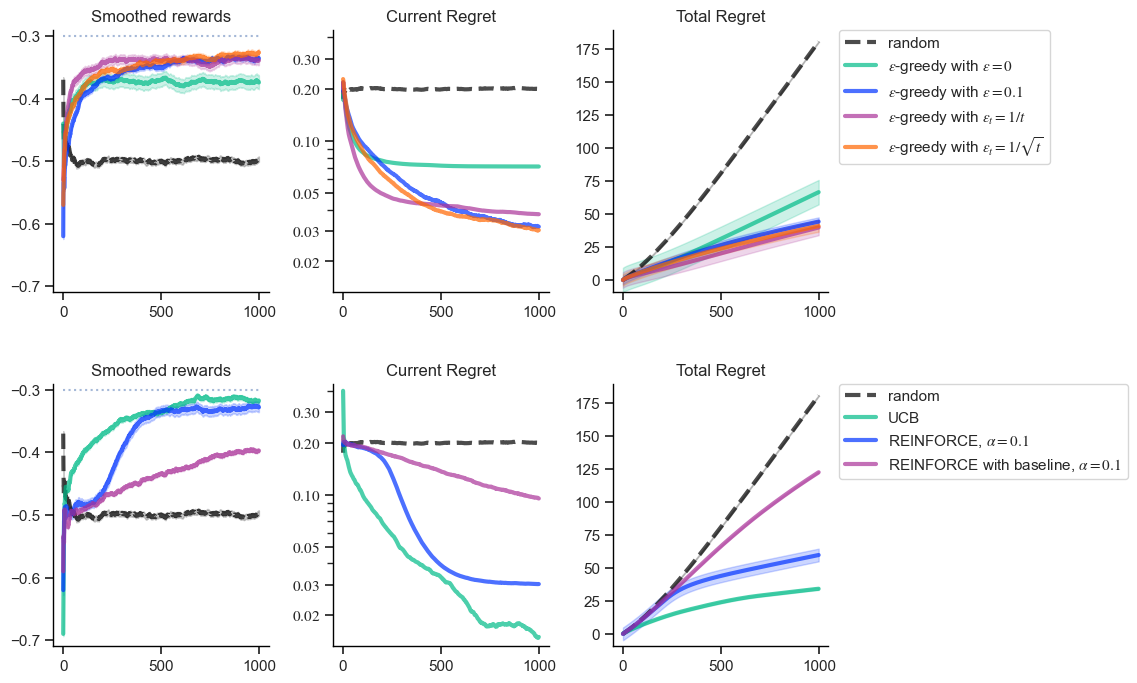

In [29]:
experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.


### UCB

- **UCB**: No significant change observed. Its confidence-based exploration ensures that all arms are tried sufficiently, making it robust to the altered reward dynamics.


### REINFORCE Algorithms

- **REINFORCE (α = 0.1)**: Slightly worse performance than in Experiment 1. Because the successful action now gives zero reward, there's no positive learning signal, slowing convergence.

- **REINFORCE with baseline (α = 0.1)**: Performance remains largely unchanged. The baseline helps the model differentiate between relatively good and bad actions even with sparse rewards.

### ε-greedy Algorithms

- **ε = 0 (greedy)**: Performance improved significantly compared to Experiment 1. With initial Q-values set to zero and negative rewards for suboptimal arms, the greedy agent is implicitly forced to try different actions early on.

- **εₜ = 1/t**: This variant also performs slightly better due to the negative initial feedback encouraging early exploration. However, performance gains are limited because its exploration rate still decays quickly.

- **ε = 0.1** and **εₜ = 1/√t**: These algorithms show no major performance change. Since they already maintain sufficient exploration, the shift in reward structure has little effect on their learning dynamics.



## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [30]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [31]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

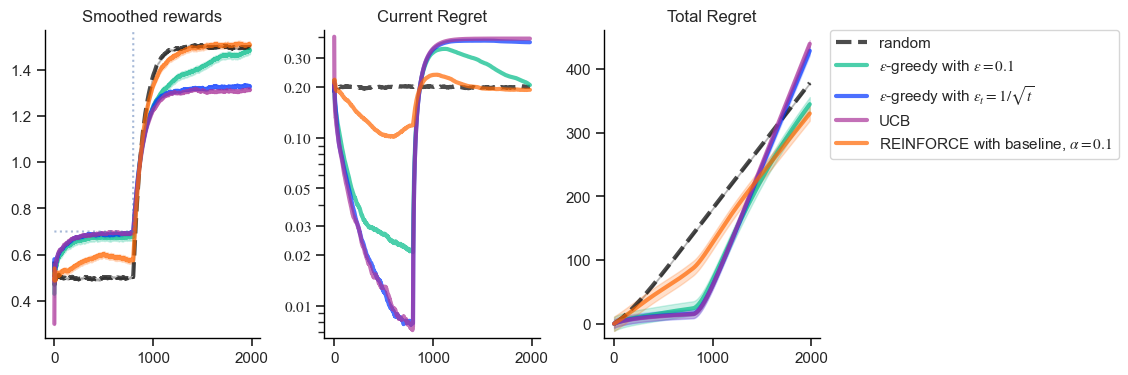

In [32]:
experiment3.show()

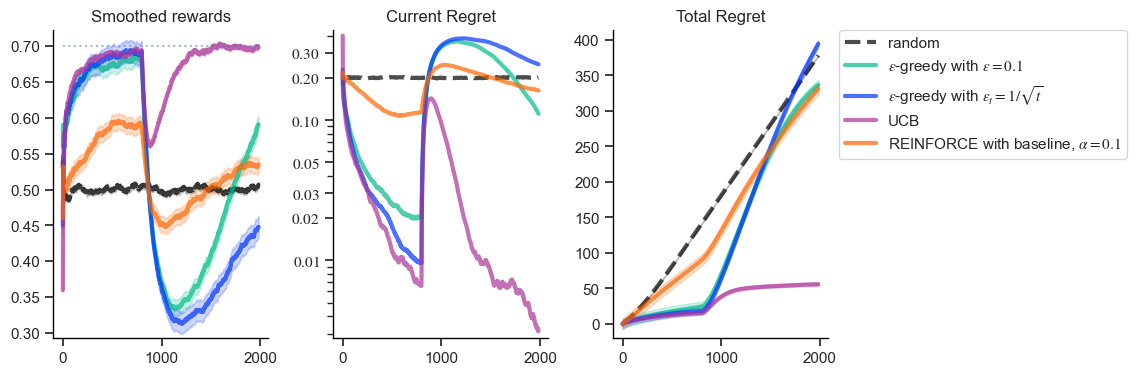

In [33]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

From worst to best:

* **ε-greedy with $εₜ = 1/\sqrt{t}$**: these fail to explore after the change and continue exploiting suboptimal "success" actions. 

* **UCB**: continues to prefer actions with historically high rewards and does not adapt quickly due to low exploration incentives.  

* **ε-greedy with $ε = 0.1$**: continues to explore and slowly adapts to the new higher reward for failure actions.  

* **REINFORCE with baseline**: updates policy directly from reward signal; since failure becomes more rewarding, policy shifts quickly toward it.


**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

From worst to best:

* **ε-greedy with $εₜ = 1/\sqrt{t}$**: purely exploits past success and never adapts to the new reward dynamics.  

* **ε-greedy with $ε = 0.1$**: explores 10% of the time, allowing slow adaptation toward now-better failure actions.  

* **REINFORCE with baseline**: learns from comparative advantage; reward boost from failure drives policy shift.  

* **UCB**: when reward from success drops to 0, UCB rapidly shifts exploration to failure actions whose empirical means now increase faster.

**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

In experiment 3, success still yields positive rewards, so UCB sees no signal to shift away from it — regret plateaus at a high level. In experiment 4, success yields 0 and failure becomes better, so UCB's optimism forces it to explore, leading to fast adaptation and decreasing regret. Thus, the key difference is whether UCB's current best arm continues receiving positive updates — it doesn't in experiment 4.

**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

To handle non-stationarity, UCB should place more weight on recent rewards and reduce reliance on outdated observations. Two possible modifications are:

- **Discounted UCB**: Applies an exponential discount factor γ ∈ (0,1) to past rewards and action counts, so older data has diminishing influence. This allows the algorithm to adapt gradually as reward distributions shift over time.

- **Sliding Window UCB**: Maintains statistics over a fixed-size window of the most recent τ steps, completely discarding older data. This approach reacts faster to abrupt changes, making it better suited for environments with sharp regime shifts.

Both methods improve responsiveness by preventing the algorithm from over-trusting stale information and keeping estimates aligned with the current environment.
